## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

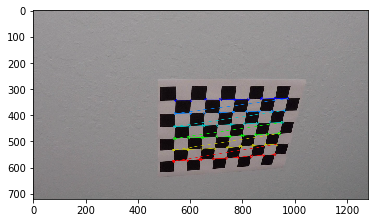

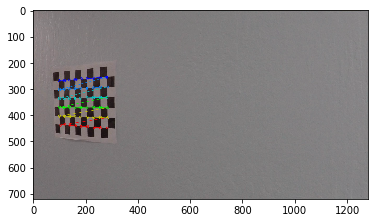

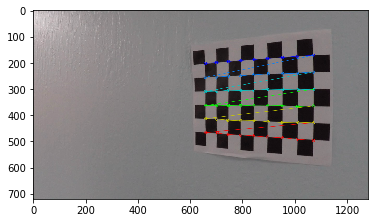

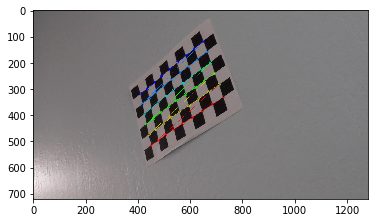

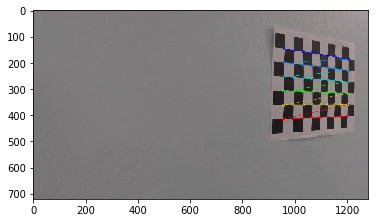

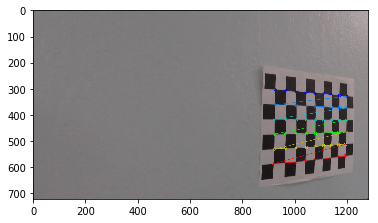

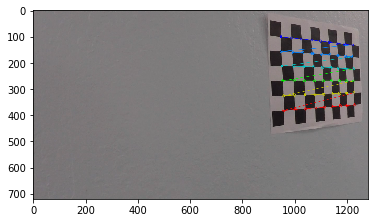

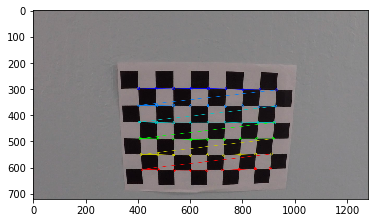

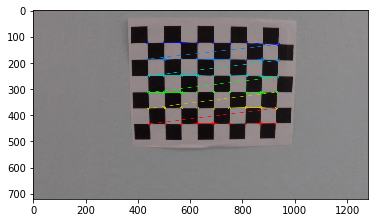

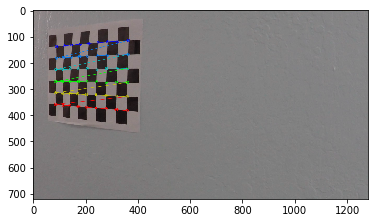

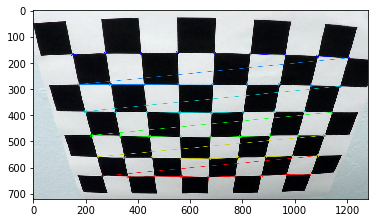

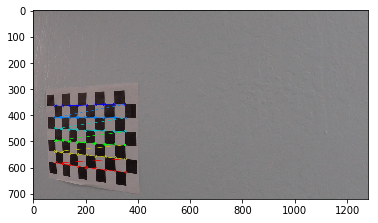

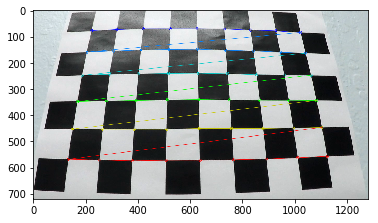

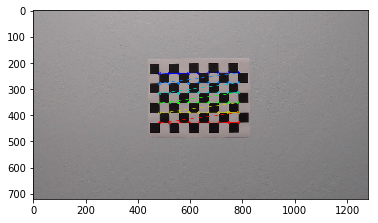

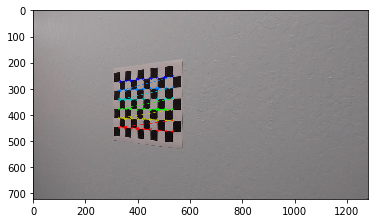

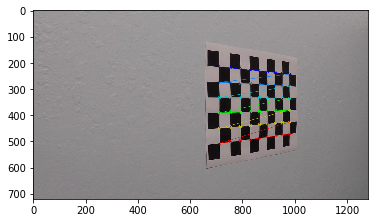

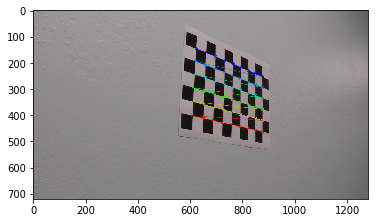

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)



## Now, I will get the undistorted matrix

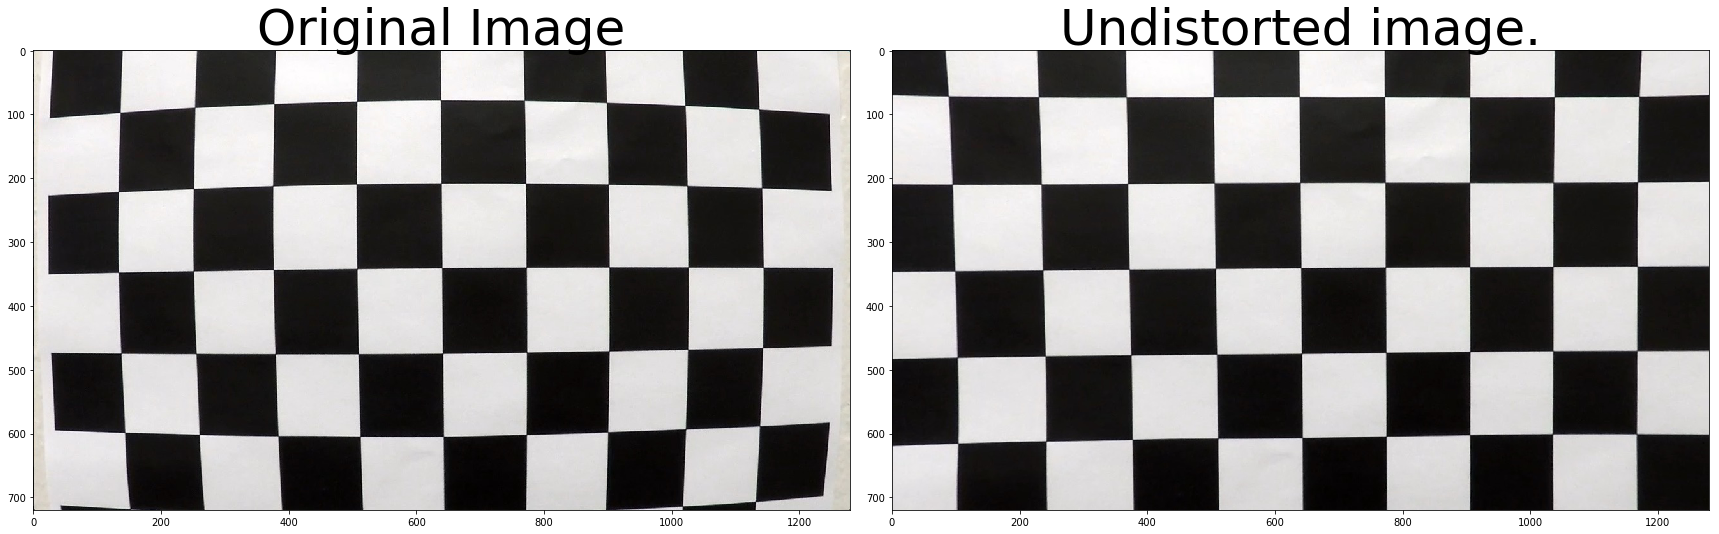

In [2]:
img = plt.imread('../camera_cal/calibration1.jpg')
[ret, mtx, dist, rves, tvecs] = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted image.', fontsize=50)

## Color threshold

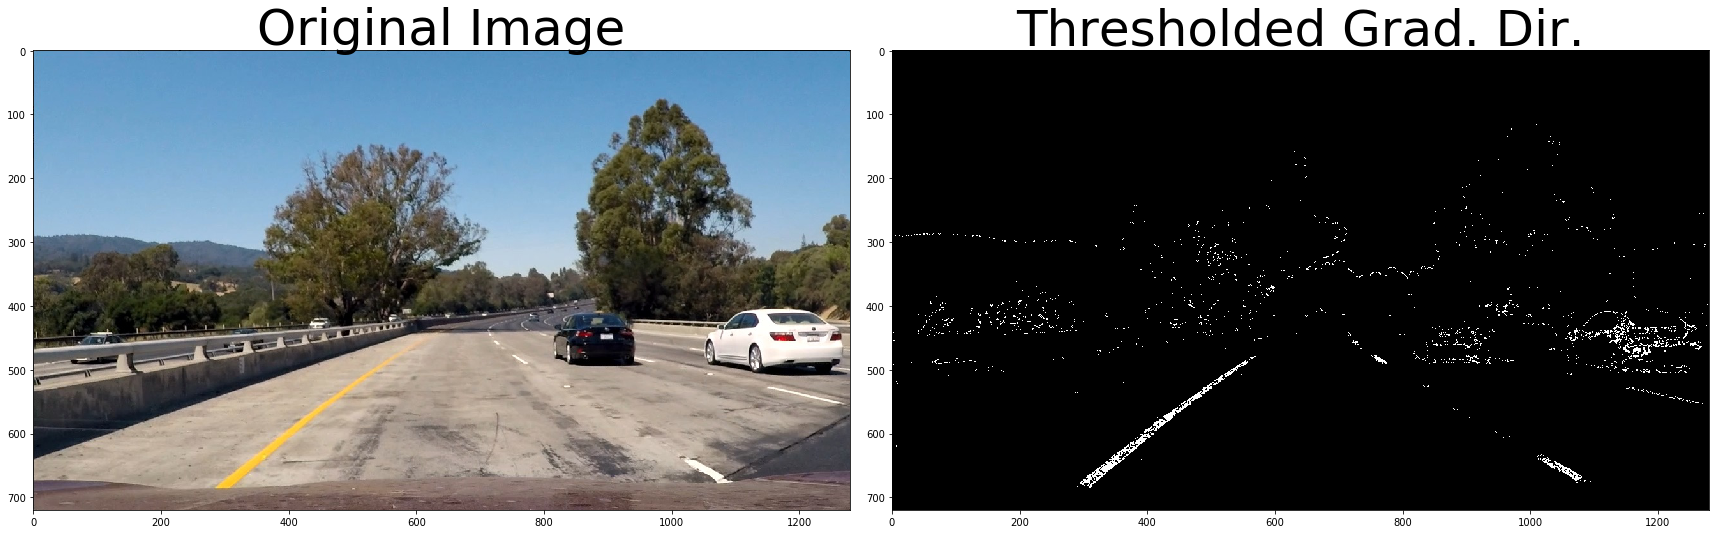

In [3]:
# Read in an image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresh(img, sobel_kernel=9, thresh=(3, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(3, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    if orient!='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def saturation_thresh(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def red_thresh(img, thresh=(200, 255)):
    R = img[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return r_binary

def blue_thresh(img, thresh=(200, 255)):
    B = img[:,:,2]
    b_binary = np.zeros_like(B)
    b_binary[(B > thresh[0]) & (B <= thresh[1])] = 1
    return b_binary

def apply_tresh(img, plot = True):
    ksize = 9
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    saturation_binary = saturation_thresh(img)
    red_binary = red_thresh(img)
    blue_binary = blue_thresh(img)
    combined = np.zeros_like(blue_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((dir_binary == 1))) & ((mag_binary == 1) & ((red_binary == 1) | (blue_binary == 1)) | (saturation_binary == 1))] = 1
    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(combined, cmap='gray')
        ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    return combined
    
sample_image = mpimg.imread('../test_images/test1.jpg')
binary = apply_tresh(sample_image)


## Now I will warp a sample image

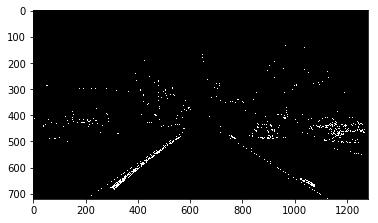

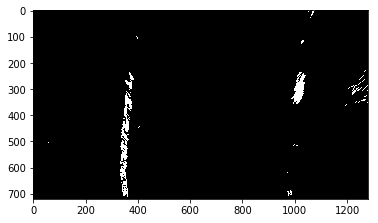

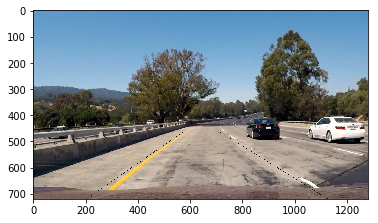

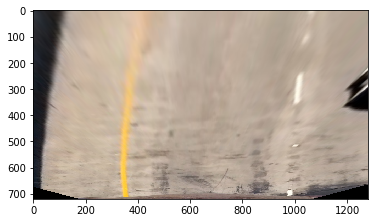

In [4]:
def warp(raw_image, plot=True):
    src_points = [(579, 460), (707,460), (1127,720), (203,720)]
    dst_points = [(320,0), (960,0), (960,720), (320,720)]
    img_cop = raw_image.copy()
    if plot:
        cv2.line(img_cop, src_points[0], src_points[3], 1)
        cv2.line(img_cop, src_points[1], src_points[2], 1)
        plt.figure()
        plt.imshow(img_cop, cmap='gray')
    # Pass in your image into this function
    # Write code to do the following steps
    undist = cv2.undistort(raw_image, mtx, dist, None, mtx)
    M = None
    warped = np.copy(undist) 
    # If found, draw corners
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    src = np.float32(src_points)
    dst = np.float32(dst_points)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    if plot:
        plt.figure()
        plt.imshow(warped, cmap='gray')
    return [warped, undist, M, Minv]

[binary_warped, binary_undist, binary_M, binary_Minv] = warp(binary)
[warped, undist, M, Minv] = warp(sample_image)

## Now I will implement sliding windows

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
def get_first_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return [ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, out_img, left_lane_inds, right_lane_inds]

[ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, out_img, left_lane_inds, right_lane_inds] = get_first_sliding_window(binary_warped)


/Users/tomascharad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Visualizing sliding window

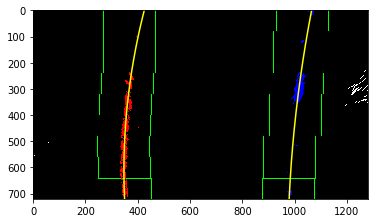

In [6]:
def visualize_sliding_window(binary_warped, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, out_img, left_lane_inds, right_lane_inds, ploty, plot=True):
#     print(binary_warped[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if plot:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

visualize_sliding_window(binary_warped, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, np.copy(out_img), left_lane_inds, right_lane_inds, ploty)

## Finding when we already have sliding window

In [7]:
def get_sliding_window(binary_warped, left_fit, right_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return [ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, ploty, left_lane_inds, right_lane_inds]

[ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, ploty, left_lane_inds, right_lane_inds] = get_sliding_window(binary_warped, left_fit, right_fit)

## Visualizing last window

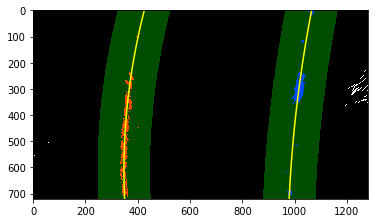

In [8]:
def visualize_last_window(binary_warped, left_fitx, right_fitx, nonzerox, nonzeroy, ploty, left_lane_inds, right_lane_inds, margin = 100, plot = True):
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if plot:
        plt.imshow(result)
        mpimg.imsave('../output_images/lanes.png', result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

visualize_last_window(binary_warped, left_fitx, right_fitx, nonzerox, nonzeroy, ploty, left_lane_inds, right_lane_inds)

## Visualizing curvature

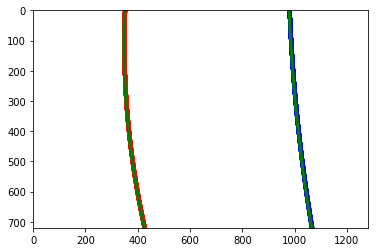

In [9]:
def visualize_curvature(ploty, left_fitx, right_fitx, plot=True):
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Plot up the fake data
    mark_size = 3
    if plot:
        plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
        plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
visualize_curvature(ploty, left_fitx, right_fitx)


## Calculating curvature

In [10]:
def get_x_from_fit(ploty, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return [left_fitx, right_fitx]

def calculate_curvature(ploty, left_fitx, right_fitx, plot=True):
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    [left_fitx, right_fitx] = get_x_from_fit(ploty, left_fit, right_fit)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if plot:
        print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    if plot:
        print(left_curverad, 'm', right_curverad, 'm')
    return [left_curverad, right_curverad]
    # Example values: 632.1 m    626.2 m
    
calculate_curvature(ploty, left_fitx, right_fitx)


2637.05264017 5191.51606877
788.524253211 m 1615.02246832 m


[788.52425321145267, 1615.0224683226857]

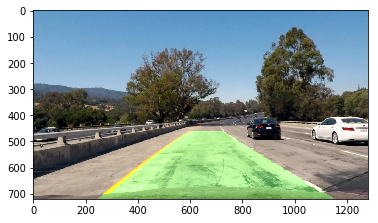

In [11]:
def draw_projected_lines(warped, left_fitx, right_fitx, ploty, image, undist, Minv, plot=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = warp_zero.copy()

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    if plot:
        plt.imshow(result)
    return result

projected_lines = draw_projected_lines(warped, left_fitx, right_fitx, ploty, sample_image, undist, Minv)

In [57]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [58]:
def sanity_check(left_fitx, right_fitx, curvature):
    is_sane = False
    curvature_similar = abs(curvature[0] - curvature[1]) < 1500
    proper_lane_separation = (430 < (right_fitx[0] - left_fitx[0])) and ((right_fitx[0] - left_fitx[0]) < 850)
    if curvature_similar and proper_lane_separation:
        is_sane = True
    return is_sane

In [116]:
def get_texted_image(img, warped, ploty, undist, Minv, left_fit, right_fit, left_fitx, right_fitx, curvature, line):
    text = "No lane detected"
    text_center = ""
    projected_lines = img.copy()
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if sanity_check(left_fitx, right_fitx, curvature):
        text = "Curvature: Left " + str(int(curvature[0])) + "mts, Right: " + str(int(curvature[1])) + "mts"
        text_center = "Deviation from center: " + str(((right_fitx[0] + left_fitx[0])/2 - 350)*xm_per_pix) + "mts"
        projected_lines = draw_projected_lines(warped, left_fitx, right_fitx, ploty, img, undist, Minv, False)
        line.detected = True
        line.current_fit = [left_fit, right_fit]
        line.radius_of_curvature = curvature
    # TCT: Refactor elif, we already know that it was or wasn't detected
    elif line.detected:
        text = "Curvature*: Left " + str(int(line.radius_of_curvature[0])) + "mts, Right: " + str(int(line.radius_of_curvature[1])) + "mts"
        [last_left_fitx, last_right_fitx] = get_x_from_fit(ploty, line.current_fit[0], line.current_fit[1])
        text_center = "Deviation from center: " + str(((right_fitx[0] + left_fitx[0])/2 - 350)*xm_per_pix) + "mts"
        projected_lines = draw_projected_lines(warped, last_left_fitx, last_right_fitx, ploty, img, undist, Minv, False)
#         line.detected = True
#         line.current_fit = [line.current_fit[0], line.current_fit[1]]
#         line.radius_of_curvature = None
    texted_image = cv2.putText(img=np.copy(projected_lines), text=text, org=(50,50),fontFace=3, fontScale=1, color=(0,0,255), thickness=3)
    texted_image = cv2.putText(img=texted_image, text=text_center, org=(50,100),fontFace=3, fontScale=1, color=(0,0,255), thickness=3)
    texted_image = cv2.putText(img=texted_image, text=".", org=(int((right_fitx[0] + left_fitx[0])/2), 700),fontFace=3, fontScale=1, color=(0,0,255), thickness=3)
    return texted_image

def process_first_image(img, line = Line()):
    binary = apply_tresh(img, False)
    [binary_warped, binary_undist, binary_M, binary_Minv] = warp(binary, False)
    [warped, undist, M, Minv] = warp(img, False)
    [ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, out_img, left_lane_inds, right_lane_inds] = get_first_sliding_window(binary_warped)
    curvature = calculate_curvature(ploty, left_fitx, right_fitx, False)
    texted_image = get_texted_image(img, warped, ploty, undist, Minv, left_fit, right_fit, left_fitx, right_fitx, curvature, line)
    return texted_image

def process_other_image(img, line):
    binary = apply_tresh(img, False)
    [binary_warped, binary_undist, binary_M, binary_Minv] = warp(binary, False)
    [warped, undist, M, Minv] = warp(img, False)
    [ploty, left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, out_img, left_lane_inds, right_lane_inds] = get_sliding_window(binary_warped, line.current_fit[0], line.current_fit[1])
    curvature = calculate_curvature(ploty, left_fitx, right_fitx, False)
    texted_image = get_texted_image(img, warped, ploty, undist, Minv, left_fit, right_fit, left_fitx, right_fitx, curvature, line)
    return texted_image

In [117]:
line = Line()
def process_image(img):
    texted_image = None
    if line.detected:
        texted_image = process_other_image(img, line)
    else:
        texted_image = process_first_image(img, line)
    return texted_image

## Test on other images

In [118]:
ploty, leftx, rightx, left_fit, right_fit = (None,)*5
images = glob.glob('../test_images/test*.jpg')

# Step through the list and search for chessboard corners
processed_images = []
for fname in images:
    line = Line()
    image = mpimg.imread(fname)
    processed_image = process_image(image)
    processed_images.append(processed_image)
    mpimg.imsave('../output_images/out_' + fname.split('/')[2], processed_image)
    

## Test on videos

In [119]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
white_output = '../output_images/curvature_output.mp4'
# subclip(38,43)
clip1 = VideoFileClip("../project_video.mp4")
line = Line()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../output_images/curvature_output.mp4
[MoviePy] Writing video ../output_images/curvature_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<08:31,  2.46it/s]

  0%|          | 2/1261 [00:00<08:49,  2.38it/s]

  0%|          | 3/1261 [00:01<08:48,  2.38it/s]

  0%|          | 4/1261 [00:01<09:01,  2.32it/s]

  0%|          | 5/1261 [00:02<09:09,  2.29it/s]

  0%|          | 6/1261 [00:02<09:53,  2.12it/s]

  1%|          | 7/1261 [00:03<09:27,  2.21it/s]

  1%|          | 8/1261 [00:03<09:15,  2.26it/s]

  1%|          | 9/1261 [00:03<09:03,  2.30it/s]

  1%|          | 10/1261 [00:04<08:58,  2.32it/s]

  1%|          | 11/1261 [00:04<08:52,  2.35it/s]

  1%|          | 12/1261 [00:05<08:38,  2.41it/s]

  1%|          | 13/1261 [00:05<08:25,  2.47it/s]

  1%|          | 14/1261 [00:05<08:19,  2.50it/s]

  1%|          | 15/1261 [00:06<08:22,  2.48it/s]

  1%|▏         | 16/1261 [00:06<08:28,  2.45it/s]

  1%|▏         | 17/1261 [00:07<08:24,  2.46it/s]

  1%|▏         | 18/1261 [00:07<08:15,  2.51it/s]

  2%|▏         | 19/1261 [00:07<08:08,  2.54it/

## This video can be found here: https://drive.google.com/file/d/0B3F-Rn6bPunbcXZBSjI1b3BtWlU/view?usp=sharing